In [1]:
import os
import json
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fast')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)
print(f"Using device: {device}")

Using device: cuda


In [2]:
def fourier_residual(t, theta):
    """
    Compute the residual f_theta(t) for the Fourier series ansatz:
    x̃(t) = α sin(ω t)² + β sin(2 ω t)² + γ sin(3 ω t)²
    with parameters theta = (ω, α, β, γ)
    """
    omega, alpha, beta, gamma = theta

    sin_omega = torch.sin(omega * t)
    sin_2omega = torch.sin(2 * omega * t) 
    sin_3omega = torch.sin(3 * omega * t)
    
    x_t = alpha * sin_omega**2 + beta * sin_2omega**2 + gamma * sin_3omega**2

    factor1 = x_t - 1.0
    term_sin2 = sin_omega**2
    term_sin4 = sin_omega**4
    term_sin2_3 = sin_3omega**2

    factor2 = (2 * alpha * term_sin2 - alpha
               - 32 * beta * term_sin4 + 32 * beta * term_sin2 - 4 * beta
               + 18 * gamma * term_sin2_3 - 9 * gamma)

    f_t = 2 * omega**2 * factor1 * factor2 + x_t - x_t**2
    return f_t

def optimize_theta_for_k(k_val, N=100, n_iter=1000, lr=1e-2, print_every=500):
    """
    Optimize Fourier series parameters theta = (omega, alpha, beta, gamma)
    for given k value to minimize squared error
    """
    t_points = torch.linspace(0, 5 * np.pi, N, device=device)
    
    theta = torch.tensor([1.0, k_val, k_val/2, k_val/4], device=device, requires_grad=True)
    
    optimizer = optim.Adam([theta], lr=lr)
    
    best_loss = float('inf')
    best_theta = None
    
    for it in range(n_iter):
        optimizer.zero_grad()
        f_vals = fourier_residual(t_points, theta)
        loss = torch.mean((f_vals - k_val)**2)
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_theta = theta.detach().clone()
        
        if (it+1) % print_every == 0:
            print(f"[k = {k_val:.3f}] Iter {it+1:4d}: loss = {loss.item():.4e}   theta = {theta.data.cpu().numpy()}")
    
    return best_theta, best_loss

k_example = 0.1
best_theta, best_loss = optimize_theta_for_k(k_example)

[k = 0.100] Iter  500: loss = 1.4472e-08   theta = [ 4.67141807e-01  2.26781286e-01  6.77833017e-04 -1.23910163e-05]
[k = 0.100] Iter 1000: loss = 3.8279e-12   theta = [ 4.66675417e-01  2.26843119e-01  7.18320009e-04 -1.54204103e-05]


In [3]:
# Compare Fourier series model with a Runge-Kutta solution

def runge_kutta_ode(k, dt=1e-6, T=5*np.pi):
    """
    Solve the original ODE using RK4:
    (1-x) x'' - x² + x = k
    
    Initial conditions: x(0)=0, x'(0)=0
    """
    N_steps = int(T / dt) + 1
    t = np.linspace(0, T, N_steps)
    x = np.zeros(N_steps)
    v = np.zeros(N_steps)  # velocity = x'
    
    def f(x, v):
        denom = 1 - x
        if np.abs(denom) < 1e-8:
            denom = np.sign(denom)*1e-8
        return (k + x**2 - x) / denom
    
    for i in range(N_steps-1):
        k1x = v[i]
        k1v = f(x[i], v[i])
        
        k2x = v[i] + 0.5 * dt * k1v
        k2v = f(x[i] + 0.5 * dt * k1x, v[i] + 0.5 * dt * k1v)
        
        k3x = v[i] + 0.5 * dt * k2v
        k3v = f(x[i] + 0.5 * dt * k2x, v[i] + 0.5 * dt * k2v)
        
        k4x = v[i] + dt * k3v
        k4v = f(x[i] + dt * k3x, v[i] + dt * k3v)
        
        x[i+1] = x[i] + dt/6 * (k1x + 2*k2x + 2*k3x + k4x)
        v[i+1] = v[i] + dt/6 * (k1v + 2*k2v + 2*k3v + k4v)
        
    return t, x

def fourier_series_solution(t, theta):
    """
    Compute Fourier series x̃(t) = α sin(ω t)² + β sin(2 ω t)² + γ sin(3 ω t)²
    """
    omega, alpha, beta, gamma = theta
    return (alpha * torch.sin(omega * t)**2 +
            beta * torch.sin(2 * omega * t)**2 +
            gamma * torch.sin(3 * omega * t)**2)

[k = 0.150] Iter 1000: loss = 6.5106e-10   theta = [ 4.36490042e-01  3.76551960e-01  4.60754459e-03 -1.56429543e-04]
[k = 0.150] Iter 2000: loss = 6.5106e-10   theta = [ 4.36489995e-01  3.76551981e-01  4.60755735e-03 -1.56430523e-04]
[k = 0.100] Iter 1000: loss = 3.8279e-12   theta = [ 4.66675417e-01  2.26843119e-01  7.18320009e-04 -1.54204103e-05]
[k = 0.100] Iter 2000: loss = 3.8279e-12   theta = [ 4.66675417e-01  2.26843119e-01  7.18320009e-04 -1.54204103e-05]
[k = 0.050] Iter 1000: loss = 1.5793e-15   theta = [ 4.85832520e-01  1.05689634e-01  5.81989578e-05 -5.83741239e-07]
[k = 0.050] Iter 2000: loss = 1.5793e-15   theta = [ 4.85832520e-01  1.05689634e-01  5.81989578e-05 -5.83741239e-07]


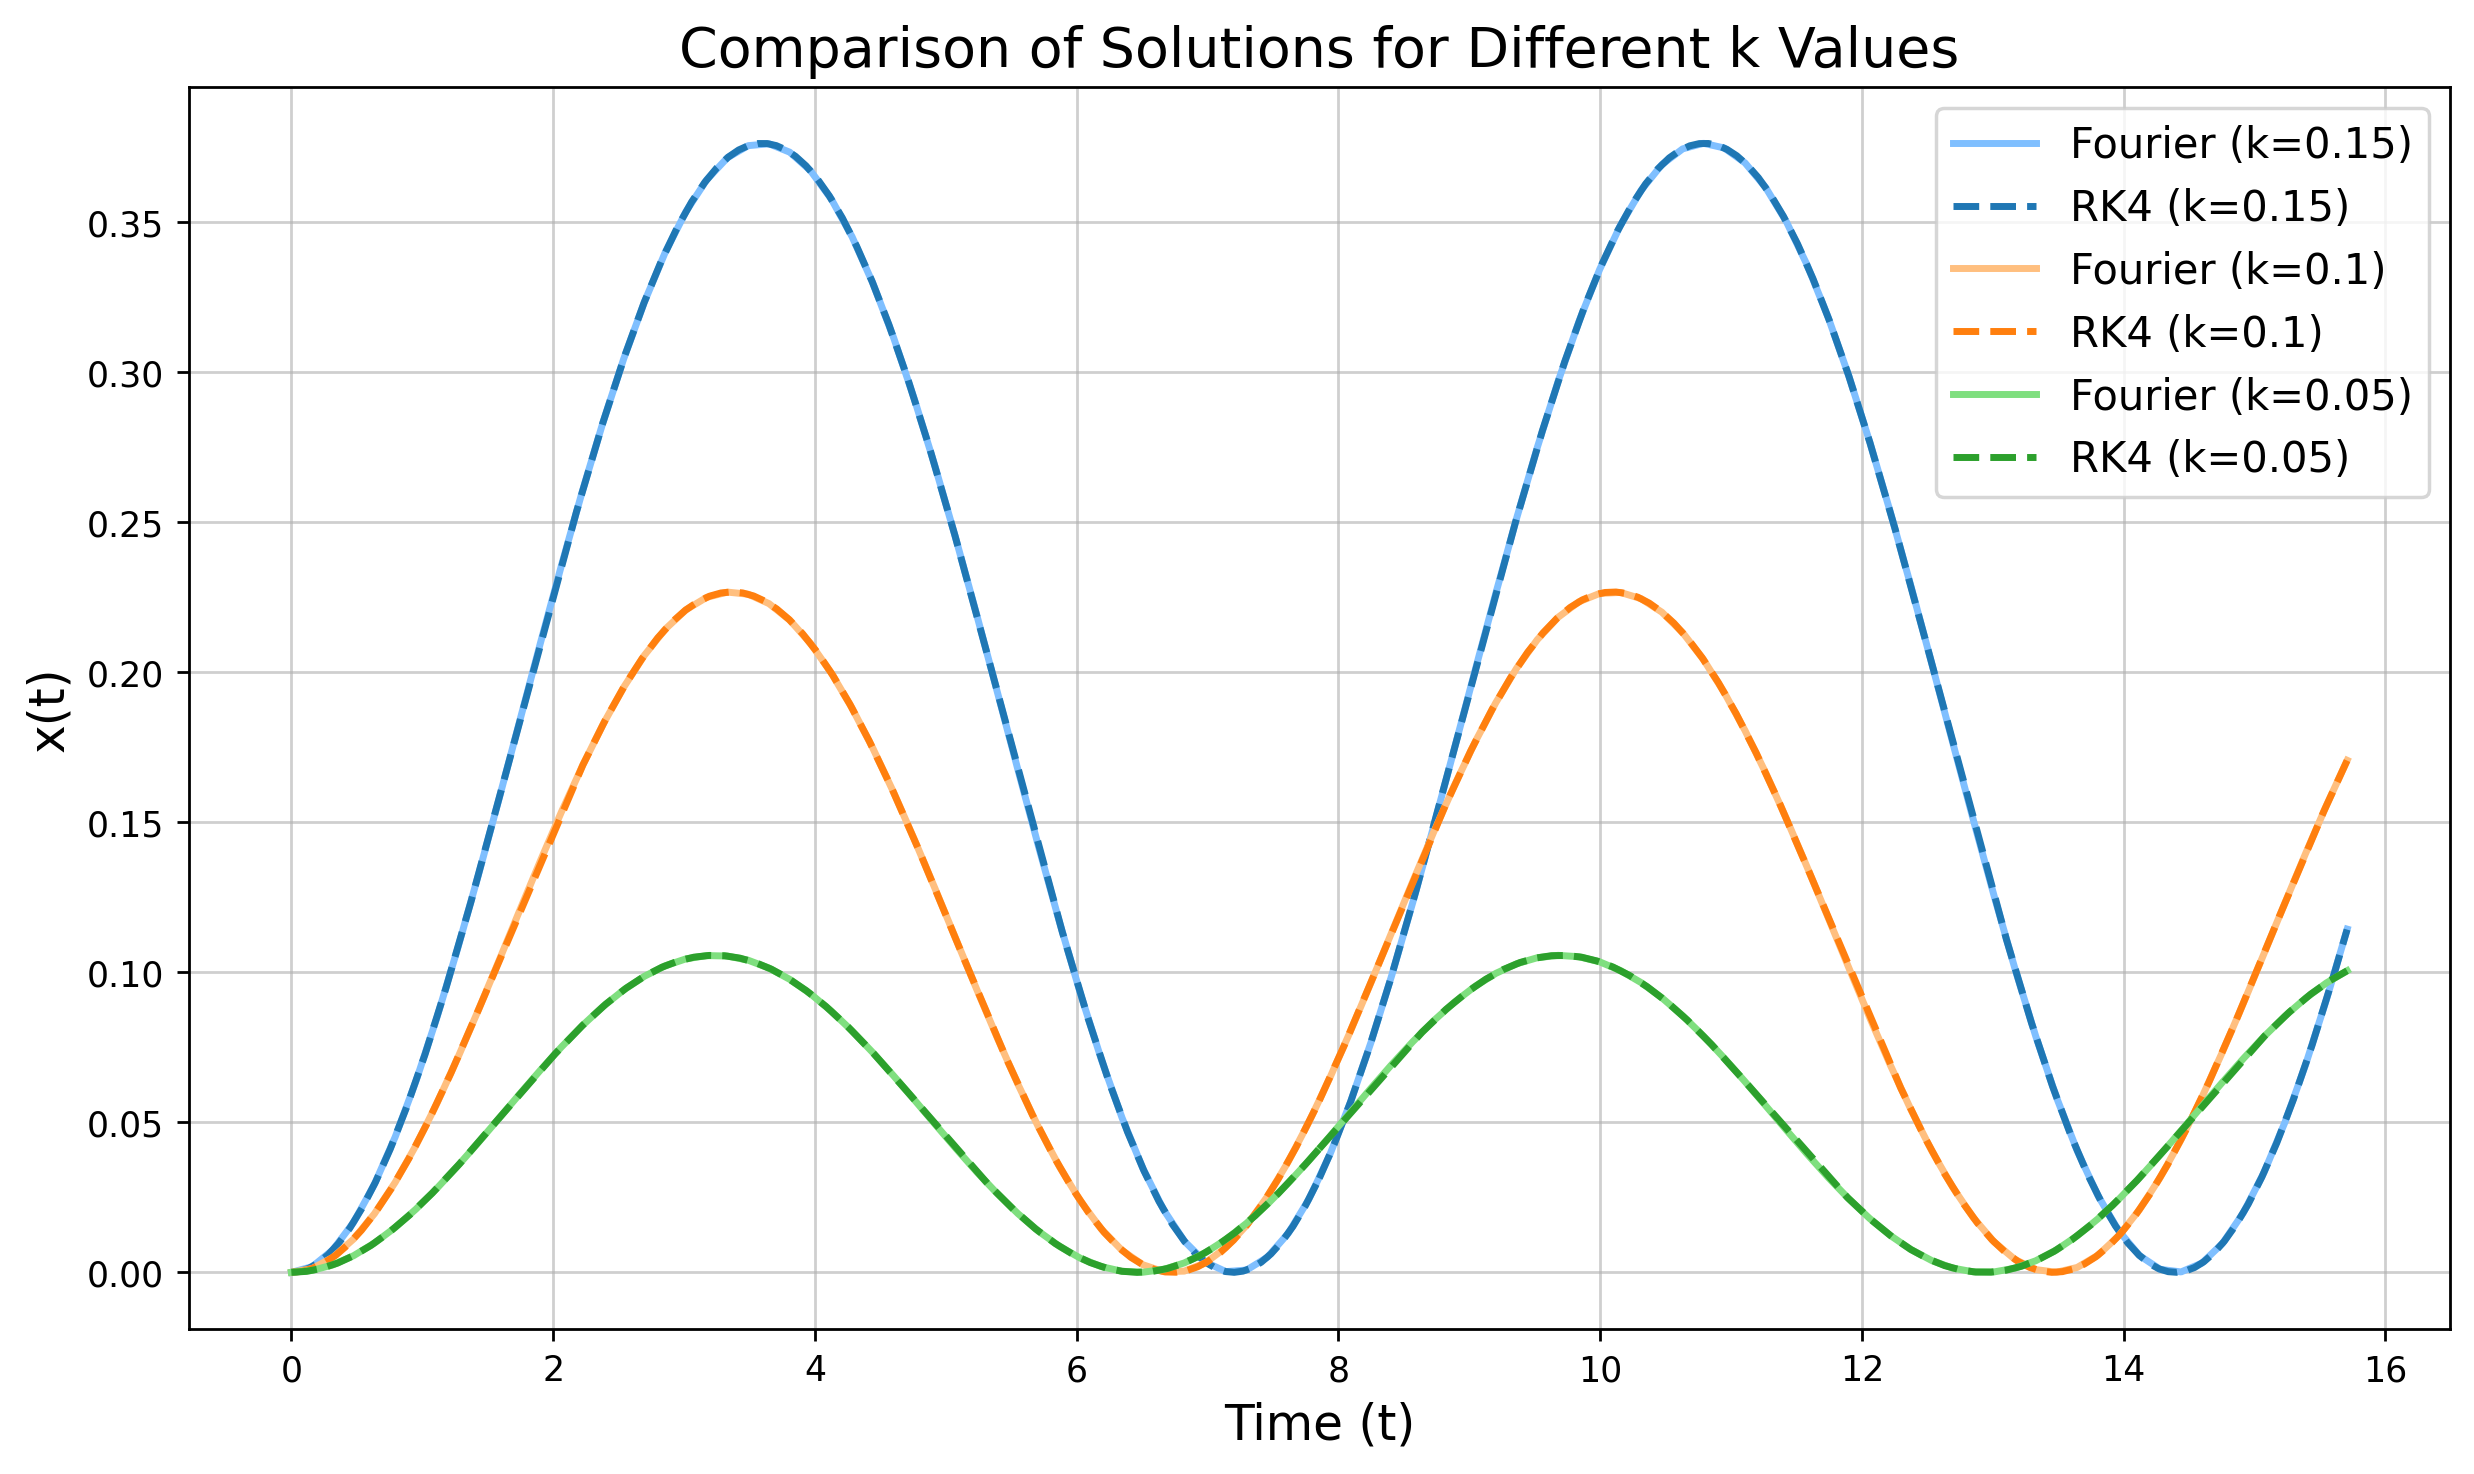

In [4]:
# Define k values to compare
k_values = [0.15, 0.1, 0.05]

# Store results for comparison plots
results = {'k_values': k_values, 't_rk': [], 'x_rk': [], 't_fourier': [], 'x_fourier': []}

plt.figure(figsize=(10, 6), dpi=250)

# Colors for plotting
light_colors = ['#7fbfff', '#ffbf7f', '#7fdf7f']  # Lighter versions
normal_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Standard colors

for i, k in enumerate(k_values):
    # RK4 solution
    t_rk, x_rk = runge_kutta_ode(k, dt=1e-5, T=5*np.pi)
    results['t_rk'].append(t_rk)
    results['x_rk'].append(x_rk)
    
    # Fourier solution
    best_theta, _ = optimize_theta_for_k(k, n_iter=2000, print_every=1000)
    t_fourier = torch.linspace(0, 5 * np.pi, 100, device=device)
    x_fourier = fourier_series_solution(t_fourier, best_theta).detach().cpu().numpy()
    results['t_fourier'].append(t_fourier.cpu().numpy())
    results['x_fourier'].append(x_fourier)
    
    plt.plot(t_fourier.cpu().numpy(), x_fourier, '-', linewidth=2,
             color=light_colors[i], label=f'Fourier (k={k})')
    plt.plot(t_rk[::100], x_rk[::100], '--', linewidth=2,
             color=normal_colors[i], label=f'RK4 (k={k})')

plt.xlabel('Time (t)', fontsize=14)
plt.ylabel('x(t)', fontsize=14)
plt.title('Comparison of Solutions for Different k Values', fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.6)
plt.tight_layout()
plt.savefig('figs/comparison_multiple_k.png', bbox_inches='tight', dpi=300)
plt.show()

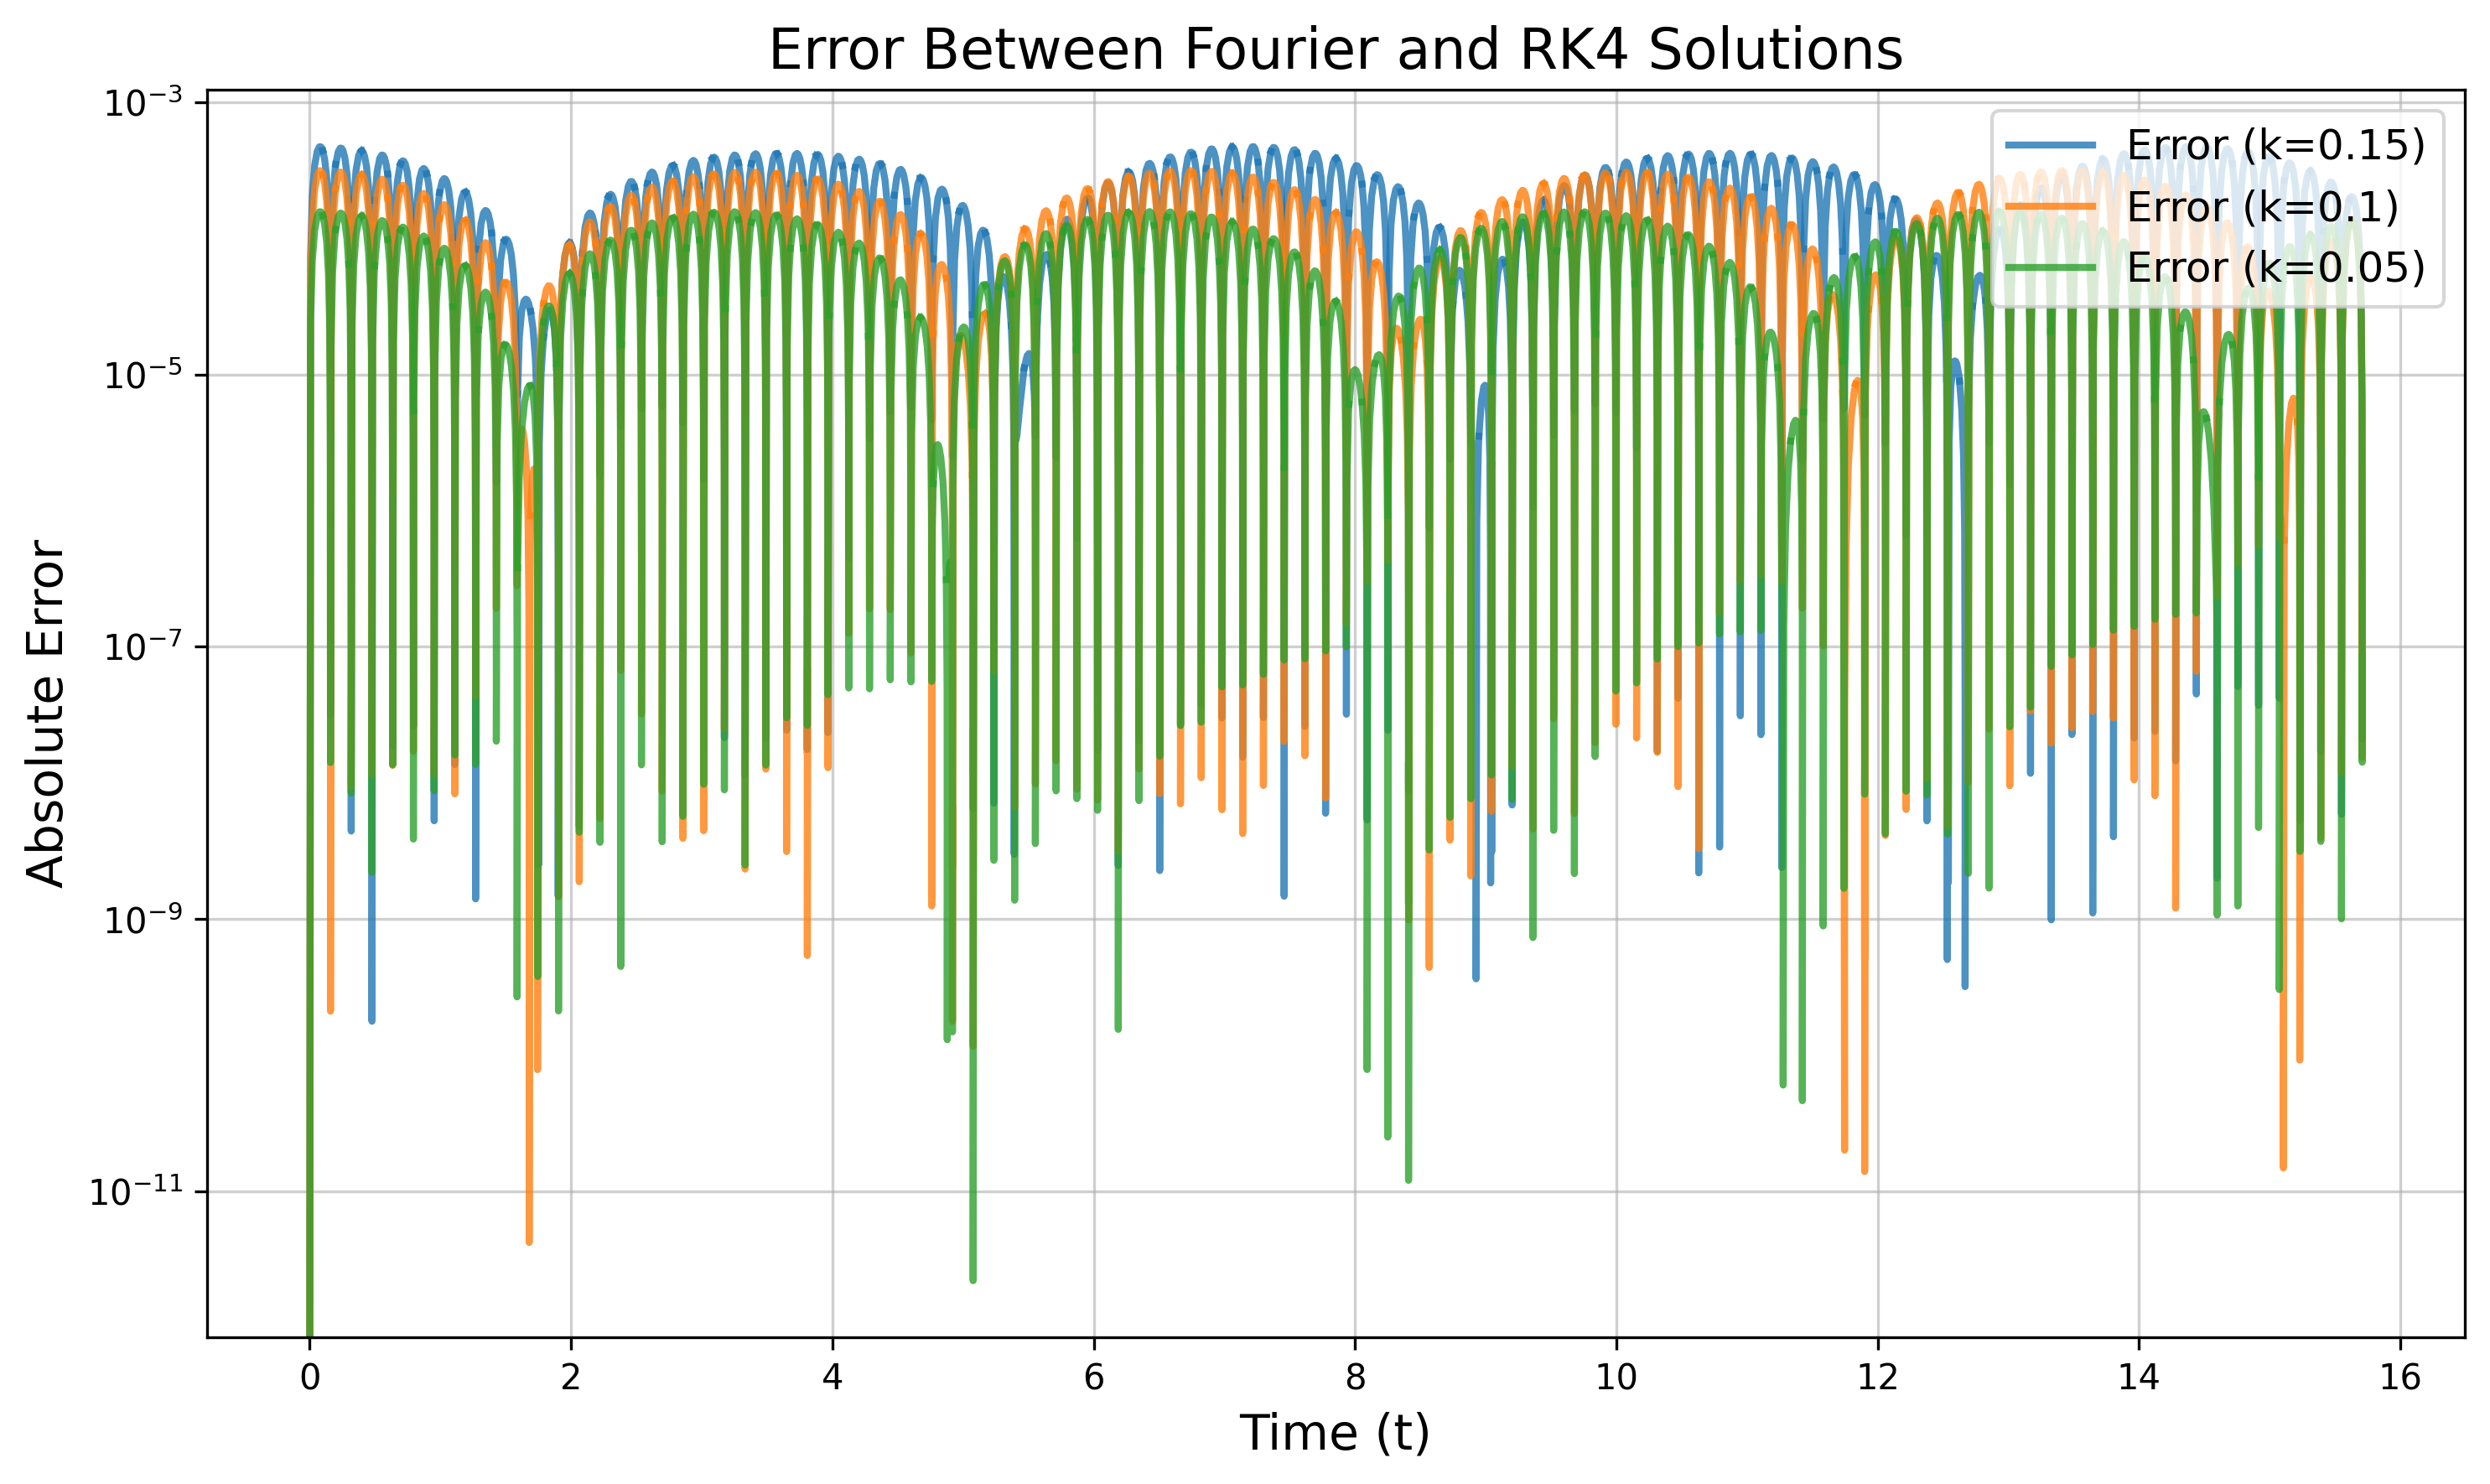

In [5]:
# Plot absolute error between Fourier and RK4 solutions
plt.figure(figsize=(10, 6), dpi=300)

for i, k in enumerate(k_values):
    x_fourier_interp = np.interp(results['t_rk'][i], results['t_fourier'][i], results['x_fourier'][i])
    error = np.abs(results['x_rk'][i] - x_fourier_interp)
    plt.plot(results['t_rk'][i], error, '-', linewidth=2,
             color=normal_colors[i], label=f'Error (k={k})', alpha=0.8)

plt.xlabel('Time (t)', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)
plt.title('Error Between Fourier and RK4 Solutions', fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.6)
plt.yscale('log')  # Using log scale to better show error magnitude
plt.tight_layout()
plt.savefig('figs/error_plot.png', bbox_inches='tight', dpi=300)
plt.show()


In [7]:
# Load or compute theta values for different k
k_star = 0.201
num_k = 100
karpathy_constant = 3e-4
file_path = 'data/theta_values.npz'

if os.path.exists(file_path):
    print("Loading precomputed theta and k values...")
    data = np.load(file_path)
    theta_values = data['theta_values']
    k_values = data['k_values']
    print("Loaded theta and k values from theta_values.npz")
else:
    k_values = np.linspace(0.002, k_star, num_k)
    theta_values = []

    print("\nOptimizing theta for different values of k...")
    for k_val in k_values:
        print(f"\nOptimizing theta for k = {k_val:.3f}...")
        theta_opt_k, _ = optimize_theta_for_k(k_val, n_iter=10000, lr=karpathy_constant, print_every=1000)
        theta_values.append(theta_opt_k.cpu().numpy())
    theta_values = np.array(theta_values)

    np.savez(file_path, 
             theta_values=theta_values,
             k_values=k_values)
    print("Saved theta and k values to theta_values.npz")

Loading precomputed theta and k values...
Loaded theta and k values from theta_values.npz


In [8]:
k_tensor = torch.tensor(k_values, device=device).unsqueeze(1)  # Shape: (num_k,1)
theta_tensor = torch.tensor(theta_values, device=device)       # Shape: (num_k,4)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 32),
            nn.GELU(),
            nn.Linear(32, 64),
            nn.GELU(),
            nn.Linear(64, 32),
            nn.GELU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.network(x)

omega_model = Net().to(device)
alpha_model = Net().to(device)
beta_model = Net().to(device)
gamma_model = Net().to(device)

optimizer_omega = optim.Adam(omega_model.parameters(), lr=1e-3)
optimizer_alpha = optim.Adam(alpha_model.parameters(), lr=1e-3)
optimizer_beta = optim.Adam(beta_model.parameters(), lr=1e-3)
optimizer_gamma = optim.Adam(gamma_model.parameters(), lr=1e-3)

# Models tuple format: (name, model, optimizer, theta_column_index, loss_history)
models = [
    ("omega",  omega_model,  optimizer_omega,  0, []),
    ("alpha",  alpha_model,  optimizer_alpha,  1, []),
    ("beta",   beta_model,   optimizer_beta,   2, []),
    ("gamma",  gamma_model,  optimizer_gamma,  3, []),
]

best_loss_for_model = [float('inf')] * len(models)
best_state_for_model = [None] * len(models)

n_epochs = 500_000
patience = 10_000
epochs_without_improvement = 0
lowest_overall_loss_sum = float('inf')

schedulers = [
    optim.lr_scheduler.CosineAnnealingLR(opt, T_max=n_epochs)
    for _, _, opt, _, _ in models
]

In [66]:
for epoch in range(1, n_epochs + 1):
    for _, _, opt, _, _ in models:
        opt.zero_grad()

    predictions = []
    for _, mdl, _, _, _ in models:
        pred = mdl(k_tensor).squeeze(1)
        predictions.append(pred)

    losses = []
    for i, (name, mdl, opt, col_idx, hist) in enumerate(models):
        true_vals = theta_tensor[:, col_idx]
        loss = torch.mean((predictions[i] - true_vals) ** 2)
        loss.backward(retain_graph=True)  # Multiple models share computation graph
        hist.append(loss.item())
        losses.append(loss.item())

        if loss.item() < best_loss_for_model[i]:
            best_loss_for_model[i] = loss.item()
            best_state_for_model[i] = mdl.state_dict()

    for i, (_, _, opt, _, _) in enumerate(models):
        opt.step()

    for i, sched in enumerate(schedulers):
        sched.step(losses[i])

    current_sum_of_losses = sum(losses)
    if current_sum_of_losses < lowest_overall_loss_sum:
        lowest_overall_loss_sum = current_sum_of_losses
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epoch % 1000 == 0:
        print(
            f"Epoch {epoch:4d}: "
            + ", ".join(
                f"loss_{m[0]}={l:.4e}" for m, l in zip(models, losses)
            )
        )

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch} due to lack of improvement.")
        break

for i, (name, mdl, opt, col_idx, hist) in enumerate(models):
    if best_state_for_model[i] is not None:
        mdl.load_state_dict(best_state_for_model[i])
    print(f"Best loss for {name} = {best_loss_for_model[i]:.4e}")

c:\Users\asus\miniconda3\envs\mama\Lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1000: loss_omega=1.2991e-04, loss_alpha=4.6396e-05, loss_beta=2.0165e-05, loss_gamma=4.8016e-08
Epoch 2000: loss_omega=6.7468e-06, loss_alpha=2.6173e-06, loss_beta=9.2441e-07, loss_gamma=4.6118e-08
Epoch 3000: loss_omega=2.5195e-06, loss_alpha=9.1367e-07, loss_beta=6.1564e-07, loss_gamma=4.2981e-08
Epoch 4000: loss_omega=8.3047e-07, loss_alpha=1.4277e-05, loss_beta=5.6486e-07, loss_gamma=3.8272e-08
Epoch 5000: loss_omega=2.5536e-07, loss_alpha=8.9334e-07, loss_beta=5.0782e-07, loss_gamma=3.1628e-08
Epoch 6000: loss_omega=1.8841e-07, loss_alpha=9.9767e-07, loss_beta=4.4686e-07, loss_gamma=2.5320e-08
Epoch 7000: loss_omega=1.3988e-07, loss_alpha=5.8608e-06, loss_beta=3.7755e-07, loss_gamma=2.0793e-08
Epoch 8000: loss_omega=1.0426e-07, loss_alpha=8.5460e-07, loss_beta=3.0233e-07, loss_gamma=1.7531e-08
Epoch 9000: loss_omega=7.9248e-08, loss_alpha=8.4417e-07, loss_beta=2.2141e-07, loss_gamma=1.5253e-08
Epoch 10000: loss_omega=6.6571e-08, loss_alpha=8.3255e-07, loss_beta=1.3079e-07, l

In [9]:
MODEL_DIR = "saved_models"

OMEGA_PATH, ALPHA_PATH, BETA_PATH, GAMMA_PATH, PARAMS_PATH = [
    os.path.join(MODEL_DIR, name) for name in (
        "omega_model.pt",
        "alpha_model.pt",
        "beta_model.pt",
        "gamma_model.pt",
        "params.json"
    )
]

def save_models_and_params():
    os.makedirs(MODEL_DIR, exist_ok=True)
    for model, path in [
        (omega_model, OMEGA_PATH),
        (alpha_model, ALPHA_PATH),
        (beta_model, BETA_PATH),
        (gamma_model, GAMMA_PATH)
    ]:
        torch.save(model.state_dict(), path)

    params = {
        'k_values': k_values.tolist(),
        'theta_values': theta_tensor.tolist()
    }
    with open(PARAMS_PATH, 'w') as f:
        json.dump(params, f)

def load_models_and_params():
    needed_files = [OMEGA_PATH, ALPHA_PATH, BETA_PATH, GAMMA_PATH, PARAMS_PATH]
    if not all(os.path.exists(f) for f in needed_files):
        return False

    for model, path in [
        (omega_model, OMEGA_PATH),
        (alpha_model, ALPHA_PATH),
        (beta_model, BETA_PATH),
        (gamma_model, GAMMA_PATH)
    ]:
        model.load_state_dict(torch.load(path))
        model.eval()

    with open(PARAMS_PATH, 'r') as f:
        params = json.load(f)
        global k_values, theta_tensor
        k_values = torch.tensor(params['k_values'])
        theta_tensor = torch.tensor(params['theta_values'])
    
    return True

if not load_models_and_params():
    save_models_and_params()

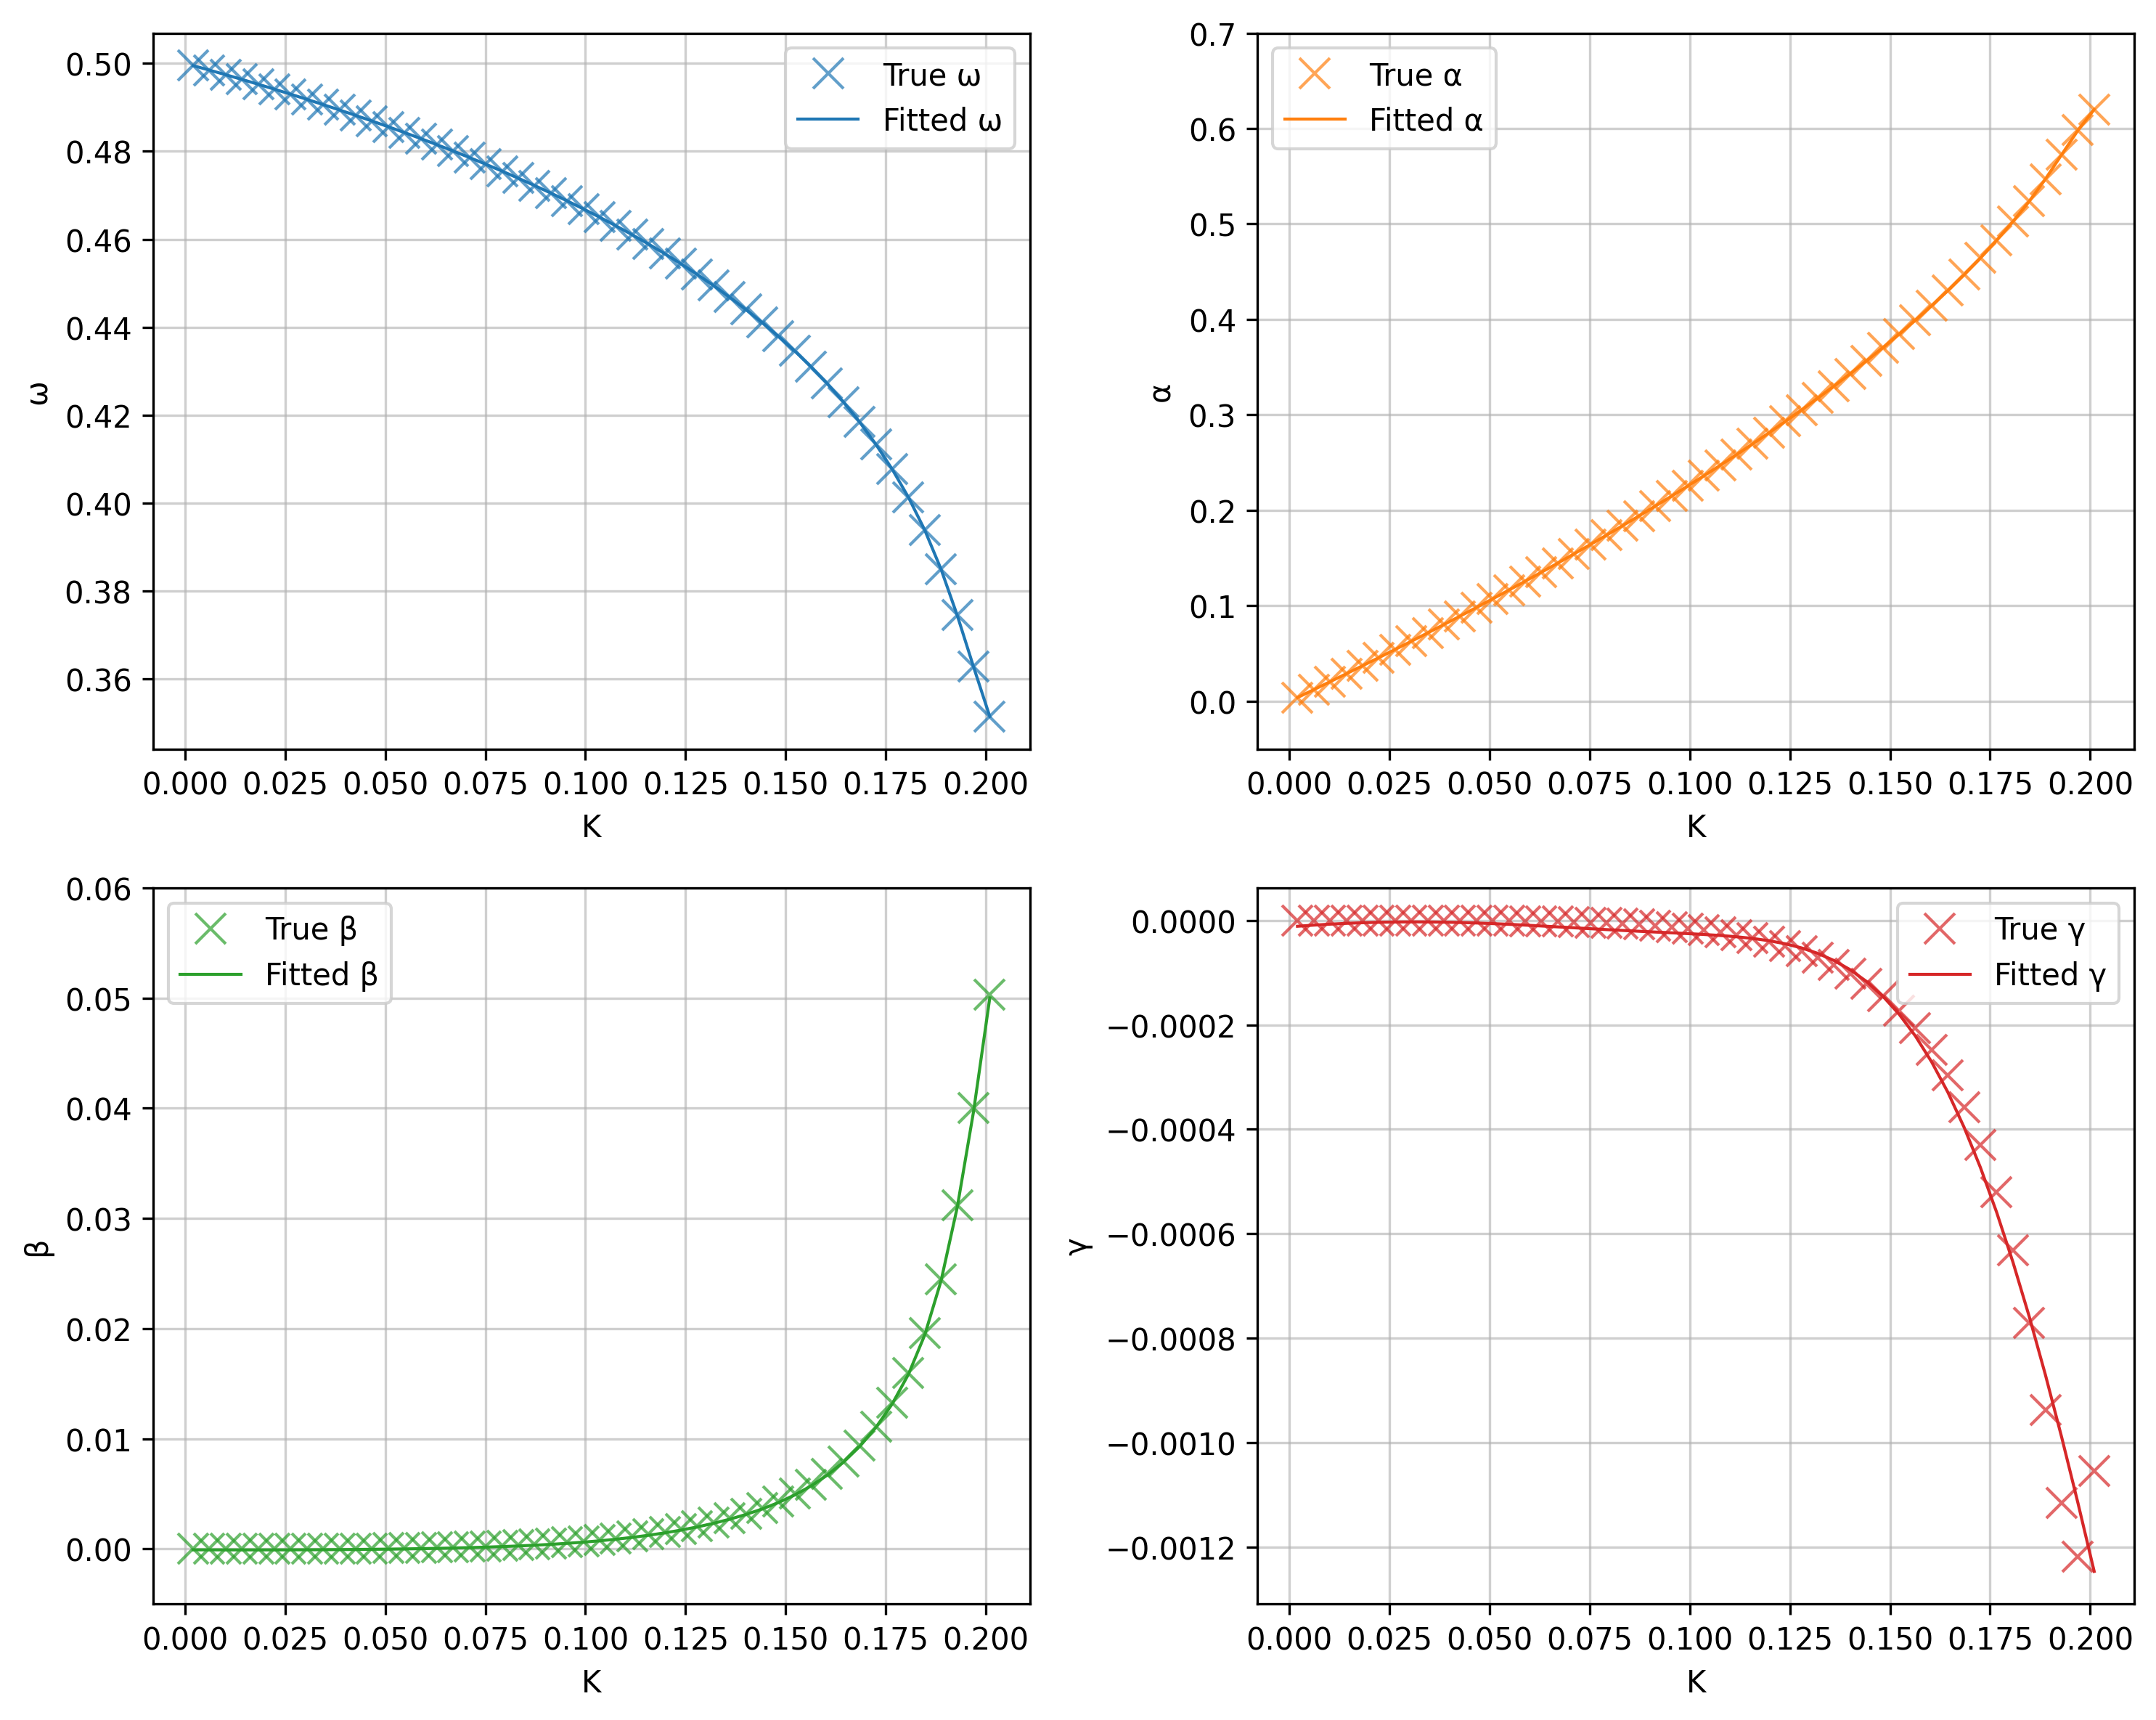


Fitted parameters for ω(k):
network.0.weight = [[-2.38134949e-01]
 [-1.18946145e+00]
 [-5.99257402e-01]
 [ 1.89651911e-01]
 [-1.05329728e+00]
 [ 4.12151530e-01]
 [ 1.64415427e+00]
 [ 2.44134225e+00]
 [ 4.42561277e-01]
 [-3.62857672e-01]
 [-5.23690151e-01]
 [ 6.49566471e-01]
 [-4.98060886e-01]
 [-4.58594010e-01]
 [ 1.19671190e+00]
 [ 1.72156402e+00]
 [ 1.39924807e+00]
 [-1.09512409e+00]
 [-4.87204596e-01]
 [-8.20450218e-01]
 [-1.25679723e+00]
 [-1.26742201e-04]
 [-9.81927261e-01]
 [ 2.28651789e+00]
 [-5.88635744e-01]
 [ 1.30208412e+00]
 [-8.73471495e-01]
 [-1.01546333e+00]
 [ 6.95064873e-01]
 [-6.51328379e-01]
 [ 1.22240813e+00]
 [-5.61916506e-01]]
network.0.bias = [-2.29838367e+00  9.53351699e-01  1.36281456e-01 -3.15428067e-02
  1.92800812e-01 -7.32377171e-02 -1.75429234e-01 -1.37470516e-01
 -8.01618168e-02  6.35468708e-02  6.03178925e-02 -2.63109343e-02
  1.02728413e-01  1.71319876e-01  2.29620579e-01 -2.63553124e-01
 -1.00925102e-01  9.38349625e-01  7.15591053e-01  3.72860894e-01
 

In [12]:
# Plot fitted curves vs true values for each parameter
plt.figure(figsize=(10, 8), dpi=300)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels = ['ω', 'α', 'β', 'γ']
models = [omega_model, alpha_model, beta_model, gamma_model]

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.grid(True, alpha=0.6)
    plt.plot(k_values, theta_tensor[:,i].cpu().numpy(), 'x', alpha=0.7, 
             label=f'True {labels[i]}', markersize=10, color=colors[i])
    plt.plot(k_values, models[i](k_tensor).detach().cpu().numpy(), '-', 
             color=colors[i], label=f'Fitted {labels[i]}', linewidth=1)
    plt.xlabel('K')
    plt.ylabel(labels[i])
    plt.xlim(min(k_values) - 0.01, max(k_values) + 0.01)
    if i == 1:
        plt.ylim(-0.05, 0.7)
    elif i == 2:
        plt.ylim(-0.005, 0.06)
    plt.legend(loc='best')

plt.tight_layout()
plt.savefig('figs/parameters.png', bbox_inches='tight', dpi=300)
plt.show()

# Print model parameters
model_params = {
    'ω(k)': omega_model,
    'α(k)': alpha_model,
    'β(k)': beta_model,
    'γ(k)': gamma_model
}

for name, model in model_params.items():
    print(f"\nFitted parameters for {name}:")
    for param_name, param in model.state_dict().items():
        print(f"{param_name} = {param.cpu().numpy()}")
    print()

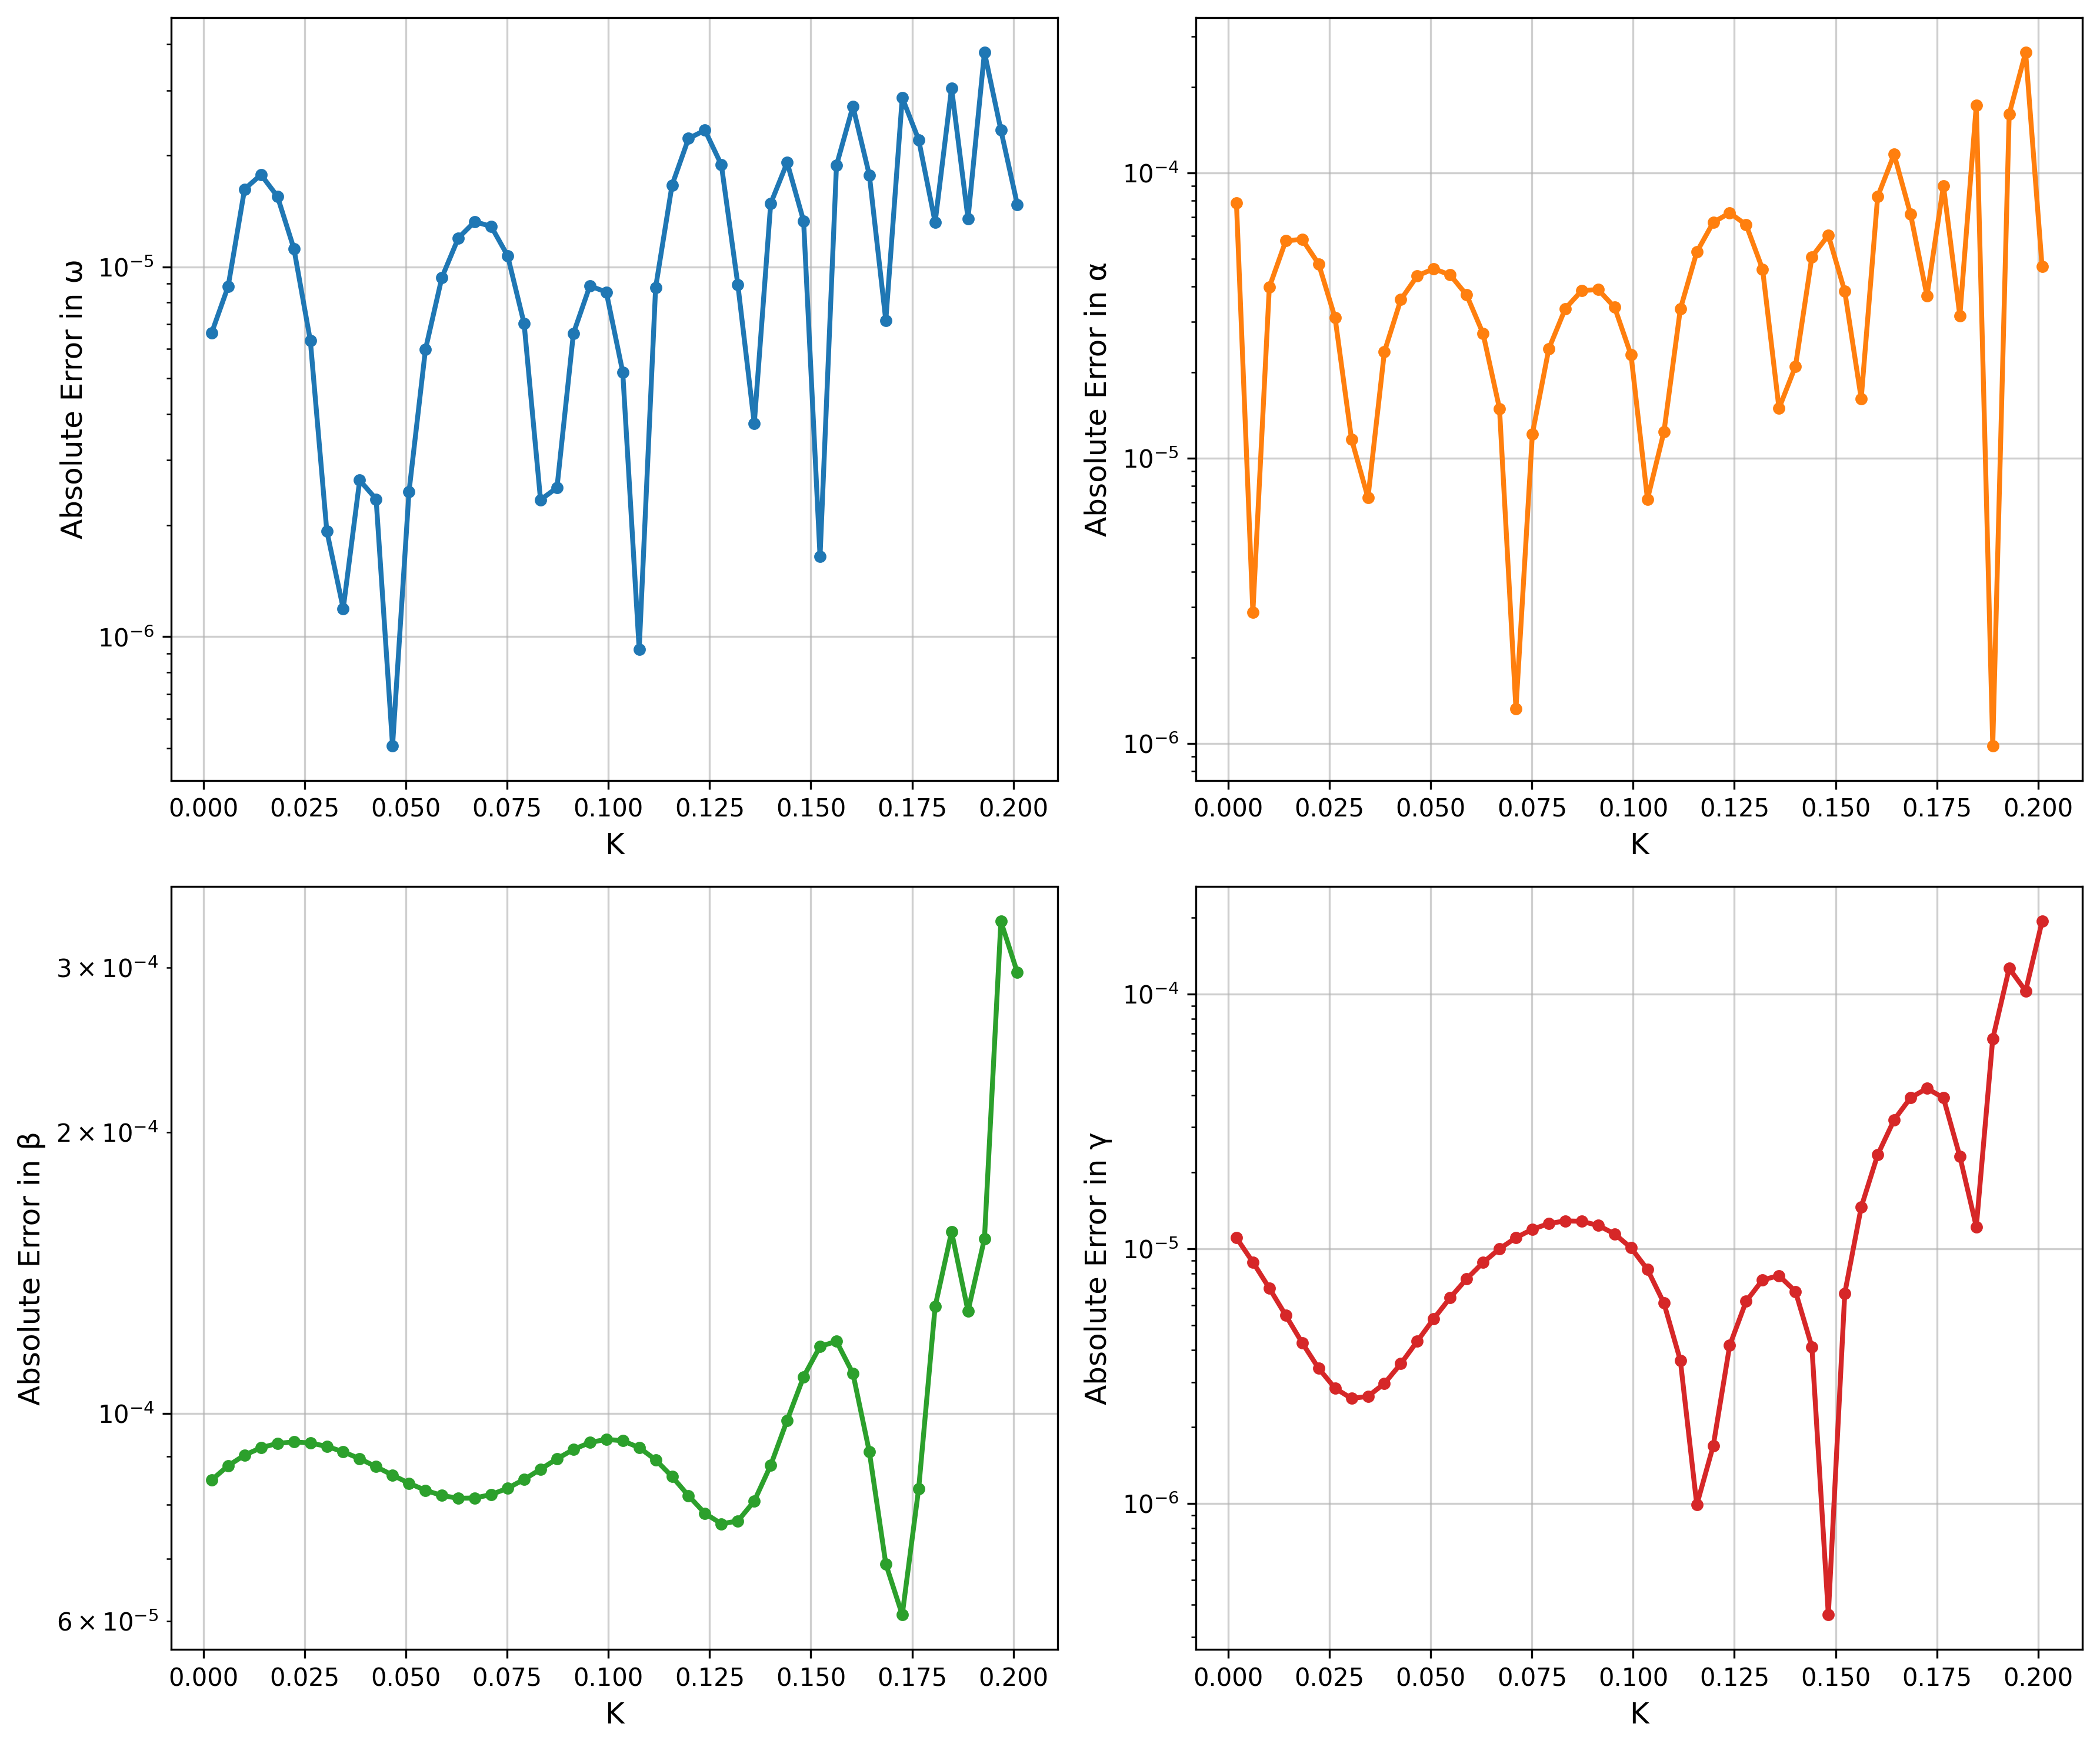

In [14]:
# Set models to evaluation mode
for model in [omega_model, alpha_model, beta_model, gamma_model]:
    model.eval()

# Get model predictions
with torch.no_grad():
    pred_omega = omega_model(k_tensor).squeeze(1)
    pred_alpha = alpha_model(k_tensor).squeeze(1)
    pred_beta  = beta_model(k_tensor).squeeze(1)
    pred_gamma = gamma_model(k_tensor).squeeze(1)

predictions = torch.stack([pred_omega, pred_alpha, pred_beta, pred_gamma], dim=1)

# Convert to numpy arrays
true_values = theta_tensor.cpu().numpy()
pred_values = predictions.cpu().numpy()

# Calculate errors
abs_errors = np.abs(true_values - pred_values)

labels = ['ω', 'α', 'β', 'γ']

# Plot errors
plt.figure(figsize=(12, 10), dpi=300)
for i, label in enumerate(labels):
    plt.subplot(2, 2, i + 1)
    plt.plot(k_values, abs_errors[:, i], 'o-', linewidth=2, markersize=4, color=colors[i])
    plt.xlabel('K', fontsize=12)
    plt.ylabel(f'Absolute Error in {label}', fontsize=12)
    plt.yscale('log')
    plt.grid(True, alpha=0.6)

plt.tight_layout()
plt.savefig('figs/absolute_errors.png', dpi=300, bbox_inches='tight')
plt.show()